In [1]:
import os
import time

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from torchsummary import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]) 

In [4]:
batch_size = 128

In [5]:
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data',train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=True)
classes = ('0', '1', '2', '3', '4','5', '6', '7', '8', '9')

In [6]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [7]:
class VGG(nn.Module):
    
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        
        self.features = self._make_layers(cfg[vgg_name])
        
        self.classifier = nn.Sequential(
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512,10),
        )

        self._initialize_weight()
        
    def forward(self, x):
        out = self.features(x)
        # entering

        # feature_before_classifier = torch.flatten(x, 1)

        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
    
    # make layers
    def _make_layers(self, cfg):
        layers = []
        in_channels = 1 # RGB initial channel is 3
        
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)] # kernel_size is 2 x 2, then step size is 2
            else:
                layers += [
                    nn.Conv2d(in_channels, x, kernel_size=3, padding=1), # are all convolution kernels of (3.3)
                    nn.BatchNorm2d(x),
                    nn.ReLU(inplace=True)
                ]
                in_channels = x 
                
        return nn.Sequential(*layers)
    
    # Initialization parameters
    def _initialize_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [8]:
net = VGG('VGG19').to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark=True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=5e-4)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5,verbose=True,patience = 5,min_lr = 1e-6) 

In [10]:
epochs = 20

In [11]:
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('The file already exists')
save_path = './model/VGG19_mnist.pth'

The file already exists


In [12]:
def get_acc(outputs, label):
    total = outputs.shape[0]
    probs, pred_y = outputs.data.max(dim=1) 
    correct = (pred_y == label).sum().data
    return correct / total

def train(net, trainloader, testloader, epoches, optimizer , criterion, scheduler=None , path = './model.pth', writer = None ,verbose = False):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    best_acc = 0
    train_acc_list, test_acc_list = [],[]
    train_loss_list, test_loss_list = [],[]
    lr_list  = []
    for i in range(epoches):
        start = time.time()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        if torch.cuda.is_available():
            net = net.to(device)
        net.train()
        for step,data in enumerate(trainloader,start=0):
            im,label = data
            im = im.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
            # formard
            outputs = net(im)
            loss = criterion(outputs,label)
            # backward
            loss.backward()
            optimizer.step()

            train_loss += loss.data
            train_acc += get_acc(outputs,label)
            rate = (step + 1) / len(trainloader)
            a = "*" * int(rate * 50)
            b = "." * (50 - int(rate * 50))
            print('\r train {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,epoches,int(rate*100),a,b),end='')
        train_loss = train_loss / len(trainloader)
        train_acc = train_acc * 100 / len(trainloader)
        if verbose:
            train_acc_list.append(train_acc.item())
            train_loss_list.append(train_loss.item())
    #     print('train_loss:{:.6f} train_acc:{:3.2f}%' .format(train_loss ,train_acc),end=' ')  
        lr = optimizer.param_groups[0]['lr']
        if verbose:
            lr_list.append(lr)

        
        # scheduler.step(train_loss)
        
        
        if testloader is not None:
            net.eval()
            with torch.inference_mode():
                for step,data in enumerate(testloader,start=0):
                    im,label = data
                    im = im.to(device)
                    label = label.to(device)
                    if hasattr(torch.cuda, 'empty_cache'):
                        torch.cuda.empty_cache()
                    outputs = net(im)
                    loss = criterion(outputs,label)
                    test_loss += loss.data
                    test_acc += get_acc(outputs,label)
                    rate = (step + 1) / len(testloader)
                    a = "*" * int(rate * 50)
                    b = "." * (50 - int(rate * 50))
                    print('\r test  {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,epoches,int(rate*100),a,b),end='')
            test_loss = test_loss / len(testloader)
            test_acc = test_acc * 100 / len(testloader)
            if verbose:
                test_loss_list.append(test_loss.item())
                test_acc_list.append(test_acc.item())
            end = time.time()
            print(
                '\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}% Test Loss:{:>.6f}  Test Acc:{:>3.2f}%  Learning Rate:{:>.6f}'.format(
                    i + 1, epoches, train_loss, train_acc, test_loss, test_acc,lr), end='')
        else:
            end = time.time()
            print('\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}%  Learning Rate:{:>.6f}'.format(i+1,epoches,train_loss,train_acc,lr),end = '')
        time_ = int(end - start)
        h = time_ / 3600
        m = time_ % 3600 /60
        s = time_ % 60
        time_str = "\tTime %02d:%02d" % ( m, s)
        if writer is not None:
            writer.add_scalars('Loss', {'train': train_loss,
                                    'valid': test_loss}, i+1)
            writer.add_scalars('Acc', {'train': train_acc ,
                                   'valid': test_acc}, i+1)
            writer.add_scalars('Learning Rate',lr,i+1)
        # =========================================================
        print(time_str)
        if test_acc > best_acc:
            torch.save(net,path)
            best_acc = test_acc
    Acc = {}
    Loss = {}
    Acc['train_acc'] = train_acc_list
    Acc['test_acc'] = test_acc_list
    Loss['train_loss'] = train_loss_list
    Loss['test_loss'] = test_loss_list
    Lr = lr_list
    return Acc, Loss, Lr

In [13]:
Acc, Loss, Lr = train(net, trainloader, testloader, epochs, optimizer, criterion, save_path, verbose = True)

Epoch [  1/ 20]  Train Loss:1.000920  Train Acc:61.07% Test Loss:1.359476  Test Acc:58.66%  Learning Rate:0.001000	Time 00:30
Epoch [  2/ 20]  Train Loss:0.381964  Train Acc:88.48% Test Loss:0.263953  Test Acc:91.71%  Learning Rate:0.001000	Time 00:32
Epoch [  3/ 20]  Train Loss:0.239494  Train Acc:93.73% Test Loss:0.290671  Test Acc:91.84%  Learning Rate:0.001000	Time 00:30
Epoch [  4/ 20]  Train Loss:0.168491  Train Acc:95.66% Test Loss:0.312670  Test Acc:91.50%  Learning Rate:0.001000	Time 00:30
Epoch [  5/ 20]  Train Loss:0.151013  Train Acc:96.23% Test Loss:0.174782  Test Acc:96.32%  Learning Rate:0.001000	Time 00:30
Epoch [  6/ 20]  Train Loss:0.133799  Train Acc:96.72% Test Loss:0.136107  Test Acc:97.18%  Learning Rate:0.001000	Time 00:32
Epoch [  7/ 20]  Train Loss:0.129079  Train Acc:96.99% Test Loss:0.215283  Test Acc:95.12%  Learning Rate:0.001000	Time 00:32
Epoch [  8/ 20]  Train Loss:0.118376  Train Acc:97.20% Test Loss:0.103061  Test Acc:97.22%  Learning Rate:0.001000	Tim

In [14]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=0)
net.eval()
for data in testloader: # Loop through each batch
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    net.eval() # Convert the model to test mode
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
    outputs = net(images) # Enter the network for testing
    
    # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0) # update the number of test images
    correct += (predicted == labels).sum() # update the number of correctly classified images

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 97.95 %


In [15]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.inference_mode():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 98.67 %
Accuracy of     1 : 98.85 %
Accuracy of     2 : 96.51 %
Accuracy of     3 : 99.50 %
Accuracy of     4 : 99.80 %
Accuracy of     5 : 97.76 %
Accuracy of     6 : 97.29 %
Accuracy of     7 : 97.18 %
Accuracy of     8 : 98.36 %
Accuracy of     9 : 96.73 %


In [16]:
def plot_history(epoches, Acc, Loss, lr):
    plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'

    epoch_list = range(1,epoches + 1)
    plt.plot(epoch_list, Loss['train_loss'])
    plt.plot(epoch_list, Loss['test_loss'])
    plt.xlabel('epoch')
    plt.ylabel('Loss Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, Acc['train_acc'])
    plt.plot(epoch_list, Acc['test_acc'])
    plt.xlabel('epoch')
    plt.ylabel('Acc Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, lr)
    plt.xlabel('epoch')
    plt.ylabel('Train LR')
    plt.show()

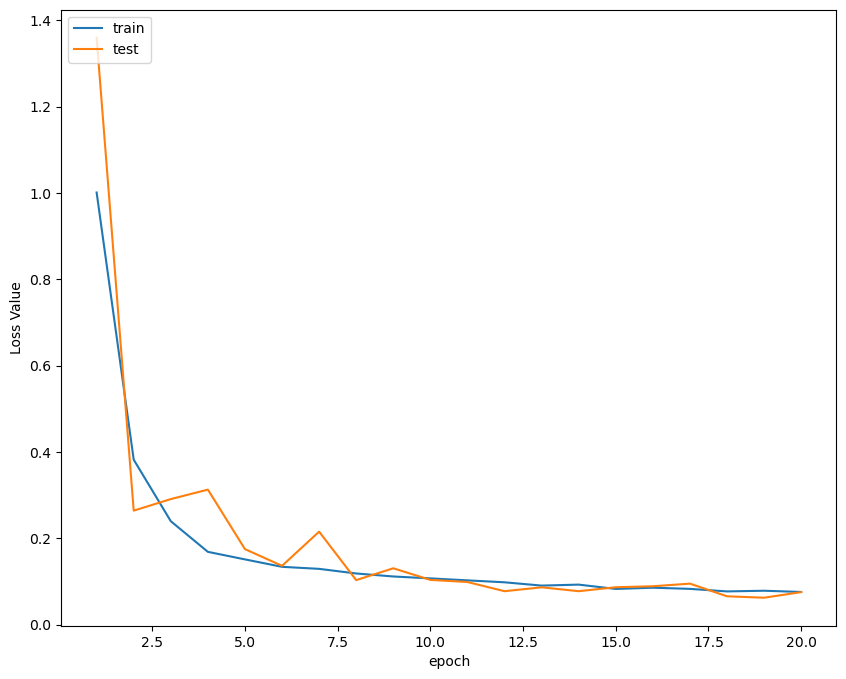

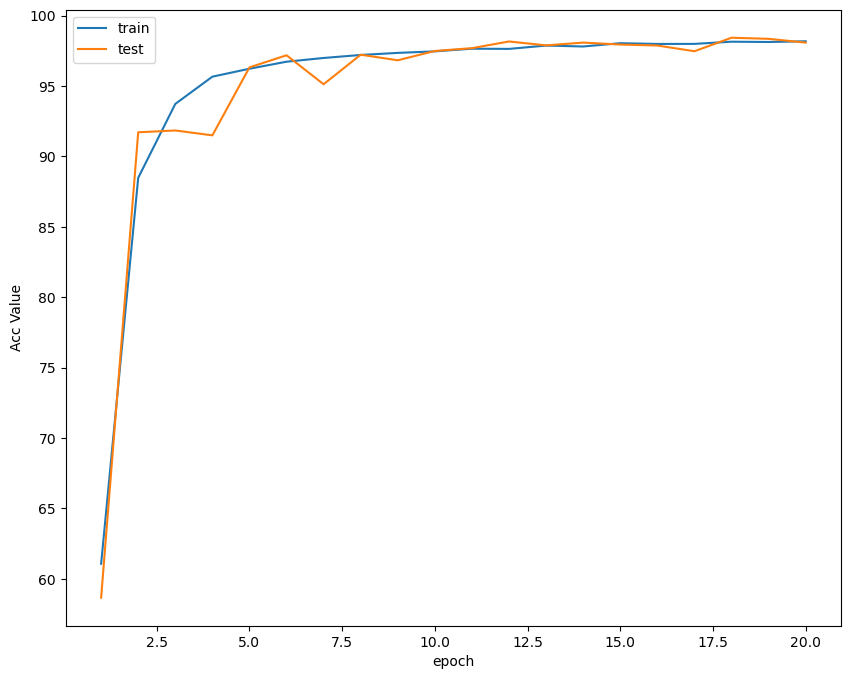

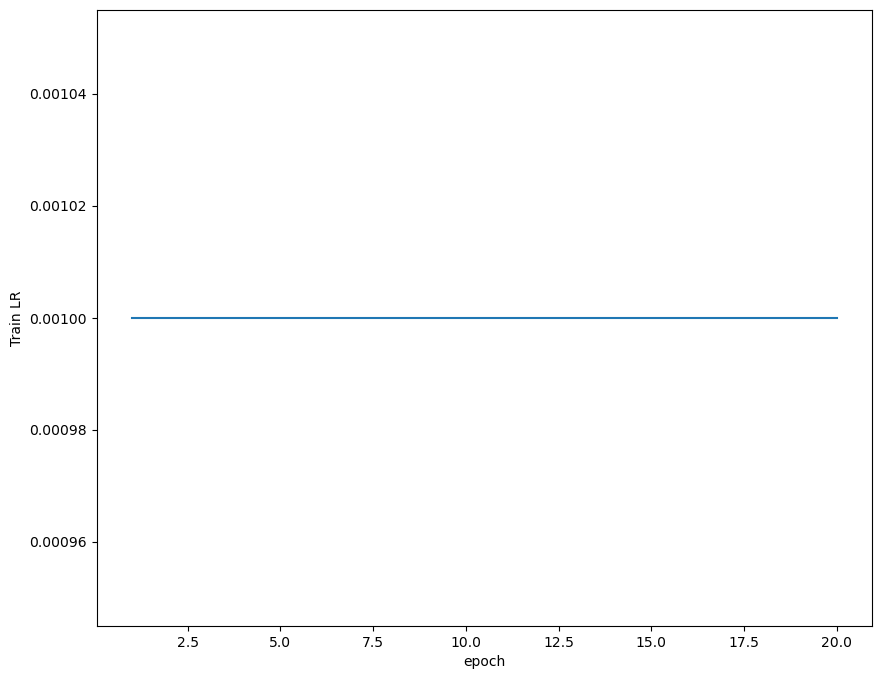

In [17]:
plot_history(epochs, Acc, Loss, Lr)

In [18]:
from itertools import product


def compute_confusion_matrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.inference_mode():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat

def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                num = conf_mat[i, j].astype(np.int64) 
                cell_text += format(num, 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
        
    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax

In [27]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

Accuracy Rate = 93.75%


<Figure size 2500x400 with 0 Axes>

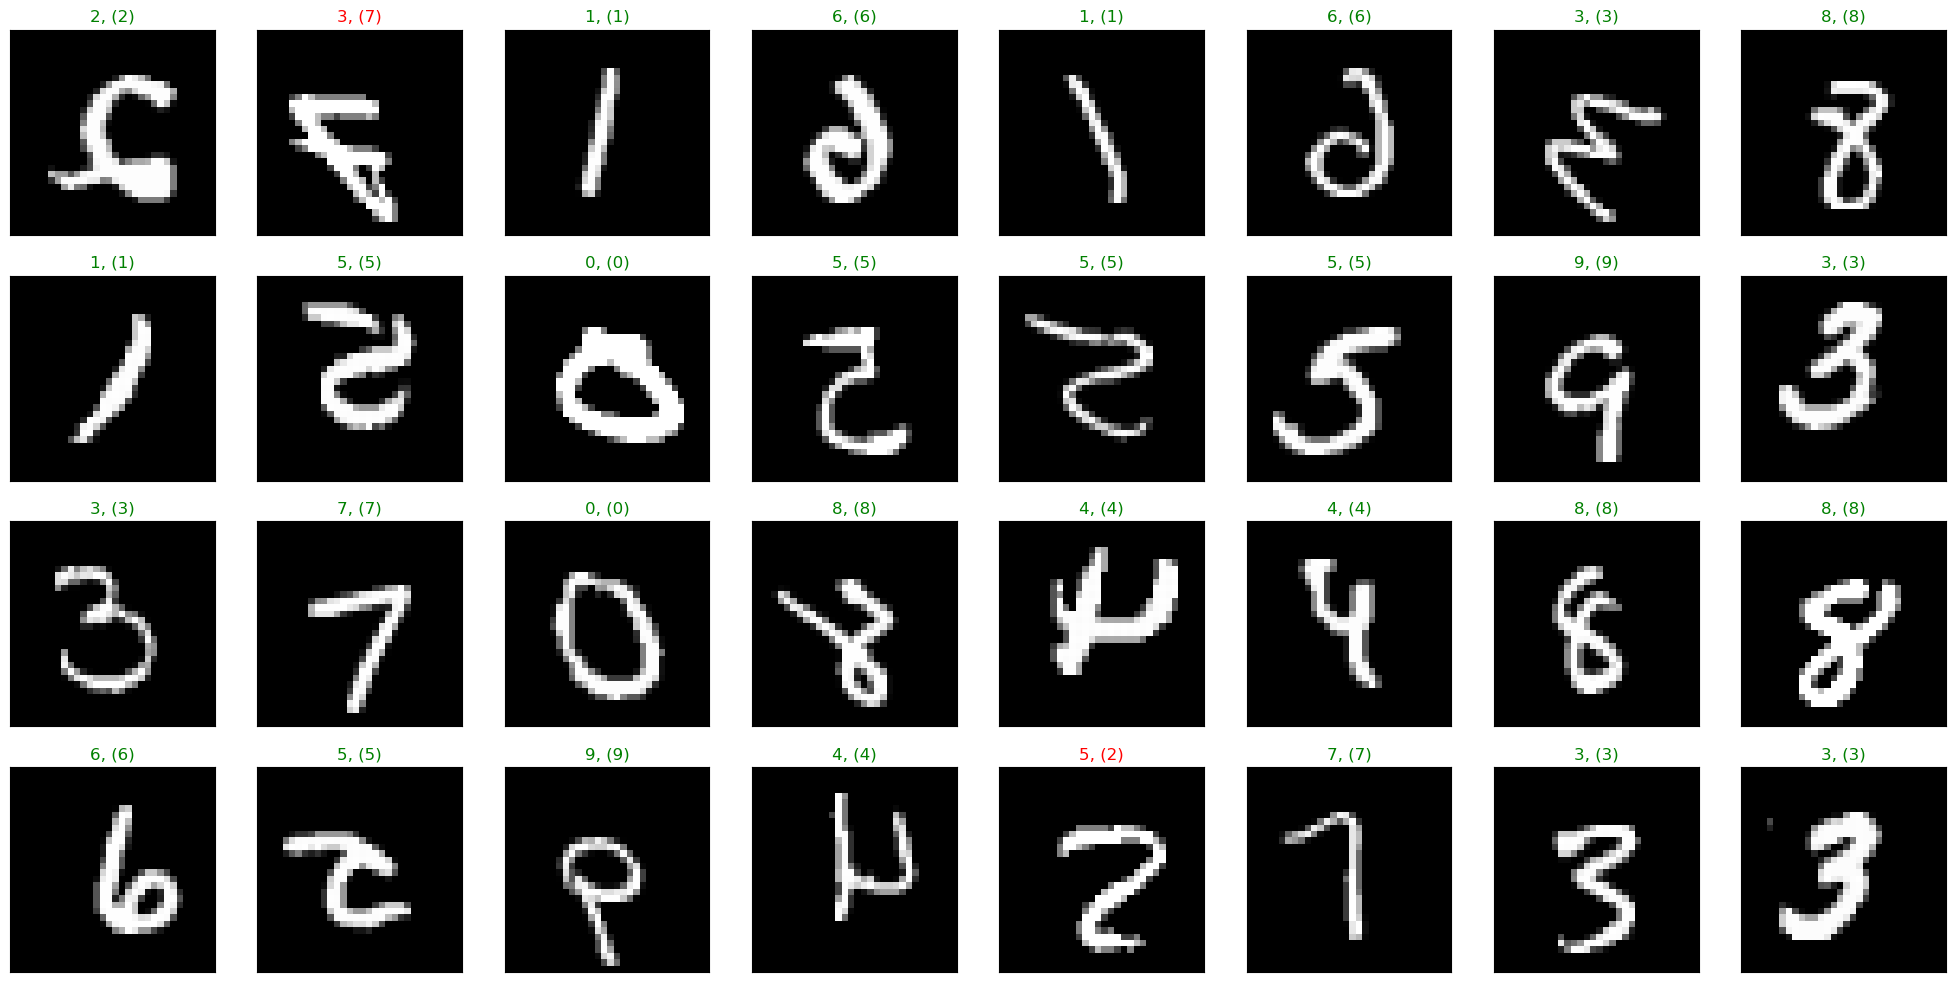

In [28]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images.cuda()
# images_ = images_
labels = labels.cuda()
val_output = net(images_).cuda()
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]),
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

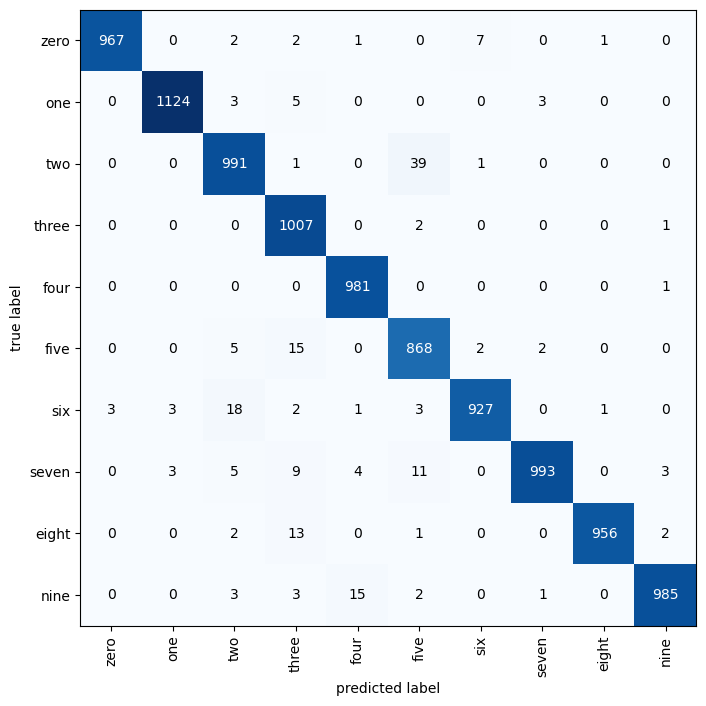

In [32]:
import numpy as np
from itertools import product


class_dict = {0: 'zero',
              1: 'one',
              2: 'two',
              3: 'three',
              4: 'four',
              5: 'five',
              6: 'six',
              7: 'seven',
              8: 'eight',
              9: 'nine'}


mat = compute_confusion_matrix(model=net.to('cpu'), data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()